In [495]:
import os
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torchvision import models
import numpy as np
import math

### Load Data

In [496]:
# The directory that I store my csv files with the embeddings.
embeddings_directory = r"C:\Nikolaos Sintoris\Education\MEng CSE - UOI\Diploma Thesis\Training Results\Layer 1\Embeddings\ResNet50 Classifier"

# Select a specific case.
current_case_name = '\\case01'
current_case_directory = embeddings_directory + current_case_name

# Load numpy array from a csv file
training_data_np = np.loadtxt(current_case_directory + '\\training_data.csv', delimiter = ',')
training_data = torch.from_numpy(training_data_np) # It does not create a copy. Uses the same memory.
training_data = training_data.float()
print("Training data shape: ", training_data.shape)

actual_training_labels_np = np.loadtxt(current_case_directory + '\\actual_training_labels.csv', delimiter = ',')
actual_training_labels = torch.from_numpy(actual_training_labels_np) # It does not create a copy. Uses the same memory.
actual_training_labels = actual_training_labels.long()
print("Actual training labels shape: ", actual_training_labels.shape)

validation_data_np = np.loadtxt(current_case_directory + '\\validation_data.csv', delimiter = ',')
validation_data = torch.from_numpy(validation_data_np) # It does not create a copy. Uses the same memory.
validation_data = validation_data.float()
print("Validation data shape: ", validation_data.shape)

actual_validation_labels_np = np.loadtxt(current_case_directory + '\\actual_validation_labels.csv', delimiter = ',')
actual_validation_labels = torch.from_numpy(actual_validation_labels_np) # It does not create a copy. Uses the same memory.
actual_validation_labels = actual_validation_labels.long()
print("Actual validation labels shape: ", actual_validation_labels.shape)

test_data_np = np.loadtxt(current_case_directory + '\\test_data.csv', delimiter = ',')
test_data = torch.from_numpy(test_data_np) # It does not create a copy. Uses the same memory.
test_data = test_data.float()
print("Test data shape: ", test_data.shape)

actual_test_labels_np = np.loadtxt(current_case_directory + '\\actual_test_labels.csv', delimiter = ',')
actual_test_labels = torch.from_numpy(actual_test_labels_np) # It does not create a copy. Uses the same memory.
actual_test_labels = actual_test_labels.long()
print("Actual test labels shape: ", actual_test_labels.shape)

Training data shape:  torch.Size([7591, 2048])
Actual training labels shape:  torch.Size([7591])
Validation data shape:  torch.Size([3254, 2048])
Actual validation labels shape:  torch.Size([3254])
Test data shape:  torch.Size([706, 2048])
Actual test labels shape:  torch.Size([706])


### Create a Feedforward Neural Network

In [497]:
# Create a feedforward NN with:
# 1 hidden layer with self.first_hidden_size neurons and Relu activation function.
# 1 output layer with 3 neurons and softmax activation function.
class MLP(torch.nn.Module):
        def __init__(self, input_size, first_hidden_size):
            super(MLP, self).__init__()
            self.input_size = input_size
            self.first_hidden_size  = first_hidden_size
            self.fc1 = torch.nn.Linear(self.input_size, self.first_hidden_size)
            self.relu = torch.nn.ReLU()
            self.fc2 = torch.nn.Linear(self.first_hidden_size, 3)
            self.softmax = torch.nn.Softmax(dim = 1)
            
            
        def forward(self, x):
            first_hidden = self.fc1(x)
            first_relu = self.relu(first_hidden)
            
            output = self.fc2(first_relu)
            output = self.softmax(output)
            return output

In [498]:
input_layer_size = training_data.shape[1]

first_hidden_layer_size = round(math.sqrt(input_layer_size * 3)) #28 - 39 - 55 - 78
print(first_hidden_layer_size)

my_model = MLP(input_layer_size, first_hidden_layer_size)

loss_function = torch.nn.CrossEntropyLoss()

learning_rate = 0.001

optimizer = torch.optim.Adam(my_model.parameters(), lr = learning_rate)

### Train model

In [499]:
# Computes the accuracy.
def compute_accuracy(predictions, labels):
    # Take the max value and the max index of every vector in predictions.
    max_values, max_indexes = torch.max(predictions.data, 1)
    # Compute the accuracy.
    accuracy = (((max_indexes == labels).sum().item()) / labels.shape[0]) * 100
    return accuracy

def train_model(model, data, actual_labels):
    # Set train mode.
    model.train()
    
    # Sets the gradients to zero before we start backpropagation
    optimizer.zero_grad()
    
    # Forward pass - compute labels.
    predicted_training_labels = model(data)
    
    # Calculate cross entropy loss.
    loss = loss_function(predicted_training_labels, actual_labels)
    
    # Calculate accuracy.
    accuracy = compute_accuracy(predicted_training_labels, actual_labels)
    
    # Computes the gradients.
    loss.backward()
    
    # Update the parameters.
    optimizer.step()
    
    return loss.item()
    
def test_model(model, data, actual_labels):
    # Set evaluation mode.
    model.eval()
    
    # Compute predicted labels.
    predicted_test_labels = model(data)
    
    # Compute accuracy.
    final_accuracy = compute_accuracy(predicted_test_labels, actual_labels)
    
    return final_accuracy, predicted_test_labels

In [500]:
# I have 8000 epochs.
# In each epoch
#  a) Train the model
#  b) Test the model
#  c) Print accuracy on the test data.
# Every 10 epochs I compute the accuracy on the validation test.
# I save the model with the maximum validation accuracy and with that model I finally compute the accuracy on the test data.

best_model_directory = r"C:\Nikolaos Sintoris\Education\MEng CSE - UOI\Diploma Thesis\Training Results\Layer 1\Best Model\ResNet50 Classifier"
current_case_best_model_directory = best_model_directory + current_case_name

if not os.path.exists(current_case_best_model_directory):
    os.makedirs(current_case_best_model_directory)

number_of_epochs = 8000
epoch_list = [x for x in range(number_of_epochs)]
accuracy_list = []
training_loss_list = []
max_validation_accuracy = 0.0
# Specify a path
PATH = current_case_best_model_directory + "\state_dict_model.pt"
for epoch in range(number_of_epochs):
    print("Epoch: ", epoch)
    if(((epoch % 10) == 0) and (epoch > 0)):
        validation_accuracy, _ = test_model(my_model, validation_data, actual_validation_labels)
        accuracy_list.append(validation_accuracy)
        training_loss_list.append(training_loss_list[-1])

        if(validation_accuracy >= max_validation_accuracy):
            max_validation_accuracy = validation_accuracy
            # Save the model with the maximum validation accuracy.
            torch.save(my_model.state_dict(), PATH)
        continue 
        
    current_training_loss = train_model(my_model, training_data, actual_training_labels)
    training_loss_list.append(current_training_loss)
    current_training_accuracy, _ = test_model(my_model, test_data, actual_test_labels)
    accuracy_list.append(current_training_accuracy)
    
print("Max validation accuracy: ", max_validation_accuracy)

Epoch:  0
Epoch:  1
Epoch:  2
Epoch:  3
Epoch:  4
Epoch:  5
Epoch:  6
Epoch:  7
Epoch:  8
Epoch:  9
Epoch:  10
Epoch:  11
Epoch:  12
Epoch:  13
Epoch:  14
Epoch:  15
Epoch:  16
Epoch:  17
Epoch:  18
Epoch:  19
Epoch:  20
Epoch:  21
Epoch:  22
Epoch:  23
Epoch:  24
Epoch:  25
Epoch:  26
Epoch:  27
Epoch:  28
Epoch:  29
Epoch:  30
Epoch:  31
Epoch:  32
Epoch:  33
Epoch:  34
Epoch:  35
Epoch:  36
Epoch:  37
Epoch:  38
Epoch:  39
Epoch:  40
Epoch:  41
Epoch:  42
Epoch:  43
Epoch:  44
Epoch:  45
Epoch:  46
Epoch:  47
Epoch:  48
Epoch:  49
Epoch:  50
Epoch:  51
Epoch:  52
Epoch:  53
Epoch:  54
Epoch:  55
Epoch:  56
Epoch:  57
Epoch:  58
Epoch:  59
Epoch:  60
Epoch:  61
Epoch:  62
Epoch:  63
Epoch:  64
Epoch:  65
Epoch:  66
Epoch:  67
Epoch:  68
Epoch:  69
Epoch:  70
Epoch:  71
Epoch:  72
Epoch:  73
Epoch:  74
Epoch:  75
Epoch:  76
Epoch:  77
Epoch:  78
Epoch:  79
Epoch:  80
Epoch:  81
Epoch:  82
Epoch:  83
Epoch:  84
Epoch:  85
Epoch:  86
Epoch:  87
Epoch:  88
Epoch:  89
Epoch:  90
Epoch:  9

Epoch:  700
Epoch:  701
Epoch:  702
Epoch:  703
Epoch:  704
Epoch:  705
Epoch:  706
Epoch:  707
Epoch:  708
Epoch:  709
Epoch:  710
Epoch:  711
Epoch:  712
Epoch:  713
Epoch:  714
Epoch:  715
Epoch:  716
Epoch:  717
Epoch:  718
Epoch:  719
Epoch:  720
Epoch:  721
Epoch:  722
Epoch:  723
Epoch:  724
Epoch:  725
Epoch:  726
Epoch:  727
Epoch:  728
Epoch:  729
Epoch:  730
Epoch:  731
Epoch:  732
Epoch:  733
Epoch:  734
Epoch:  735
Epoch:  736
Epoch:  737
Epoch:  738
Epoch:  739
Epoch:  740
Epoch:  741
Epoch:  742
Epoch:  743
Epoch:  744
Epoch:  745
Epoch:  746
Epoch:  747
Epoch:  748
Epoch:  749
Epoch:  750
Epoch:  751
Epoch:  752
Epoch:  753
Epoch:  754
Epoch:  755
Epoch:  756
Epoch:  757
Epoch:  758
Epoch:  759
Epoch:  760
Epoch:  761
Epoch:  762
Epoch:  763
Epoch:  764
Epoch:  765
Epoch:  766
Epoch:  767
Epoch:  768
Epoch:  769
Epoch:  770
Epoch:  771
Epoch:  772
Epoch:  773
Epoch:  774
Epoch:  775
Epoch:  776
Epoch:  777
Epoch:  778
Epoch:  779
Epoch:  780
Epoch:  781
Epoch:  782
Epoc

Epoch:  1354
Epoch:  1355
Epoch:  1356
Epoch:  1357
Epoch:  1358
Epoch:  1359
Epoch:  1360
Epoch:  1361
Epoch:  1362
Epoch:  1363
Epoch:  1364
Epoch:  1365
Epoch:  1366
Epoch:  1367
Epoch:  1368
Epoch:  1369
Epoch:  1370
Epoch:  1371
Epoch:  1372
Epoch:  1373
Epoch:  1374
Epoch:  1375
Epoch:  1376
Epoch:  1377
Epoch:  1378
Epoch:  1379
Epoch:  1380
Epoch:  1381
Epoch:  1382
Epoch:  1383
Epoch:  1384
Epoch:  1385
Epoch:  1386
Epoch:  1387
Epoch:  1388
Epoch:  1389
Epoch:  1390
Epoch:  1391
Epoch:  1392
Epoch:  1393
Epoch:  1394
Epoch:  1395
Epoch:  1396
Epoch:  1397
Epoch:  1398
Epoch:  1399
Epoch:  1400
Epoch:  1401
Epoch:  1402
Epoch:  1403
Epoch:  1404
Epoch:  1405
Epoch:  1406
Epoch:  1407
Epoch:  1408
Epoch:  1409
Epoch:  1410
Epoch:  1411
Epoch:  1412
Epoch:  1413
Epoch:  1414
Epoch:  1415
Epoch:  1416
Epoch:  1417
Epoch:  1418
Epoch:  1419
Epoch:  1420
Epoch:  1421
Epoch:  1422
Epoch:  1423
Epoch:  1424
Epoch:  1425
Epoch:  1426
Epoch:  1427
Epoch:  1428
Epoch:  1429
Epoch:  1430

Epoch:  1993
Epoch:  1994
Epoch:  1995
Epoch:  1996
Epoch:  1997
Epoch:  1998
Epoch:  1999
Epoch:  2000
Epoch:  2001
Epoch:  2002
Epoch:  2003
Epoch:  2004
Epoch:  2005
Epoch:  2006
Epoch:  2007
Epoch:  2008
Epoch:  2009
Epoch:  2010
Epoch:  2011
Epoch:  2012
Epoch:  2013
Epoch:  2014
Epoch:  2015
Epoch:  2016
Epoch:  2017
Epoch:  2018
Epoch:  2019
Epoch:  2020
Epoch:  2021
Epoch:  2022
Epoch:  2023
Epoch:  2024
Epoch:  2025
Epoch:  2026
Epoch:  2027
Epoch:  2028
Epoch:  2029
Epoch:  2030
Epoch:  2031
Epoch:  2032
Epoch:  2033
Epoch:  2034
Epoch:  2035
Epoch:  2036
Epoch:  2037
Epoch:  2038
Epoch:  2039
Epoch:  2040
Epoch:  2041
Epoch:  2042
Epoch:  2043
Epoch:  2044
Epoch:  2045
Epoch:  2046
Epoch:  2047
Epoch:  2048
Epoch:  2049
Epoch:  2050
Epoch:  2051
Epoch:  2052
Epoch:  2053
Epoch:  2054
Epoch:  2055
Epoch:  2056
Epoch:  2057
Epoch:  2058
Epoch:  2059
Epoch:  2060
Epoch:  2061
Epoch:  2062
Epoch:  2063
Epoch:  2064
Epoch:  2065
Epoch:  2066
Epoch:  2067
Epoch:  2068
Epoch:  2069

Epoch:  2630
Epoch:  2631
Epoch:  2632
Epoch:  2633
Epoch:  2634
Epoch:  2635
Epoch:  2636
Epoch:  2637
Epoch:  2638
Epoch:  2639
Epoch:  2640
Epoch:  2641
Epoch:  2642
Epoch:  2643
Epoch:  2644
Epoch:  2645
Epoch:  2646
Epoch:  2647
Epoch:  2648
Epoch:  2649
Epoch:  2650
Epoch:  2651
Epoch:  2652
Epoch:  2653
Epoch:  2654
Epoch:  2655
Epoch:  2656
Epoch:  2657
Epoch:  2658
Epoch:  2659
Epoch:  2660
Epoch:  2661
Epoch:  2662
Epoch:  2663
Epoch:  2664
Epoch:  2665
Epoch:  2666
Epoch:  2667
Epoch:  2668
Epoch:  2669
Epoch:  2670
Epoch:  2671
Epoch:  2672
Epoch:  2673
Epoch:  2674
Epoch:  2675
Epoch:  2676
Epoch:  2677
Epoch:  2678
Epoch:  2679
Epoch:  2680
Epoch:  2681
Epoch:  2682
Epoch:  2683
Epoch:  2684
Epoch:  2685
Epoch:  2686
Epoch:  2687
Epoch:  2688
Epoch:  2689
Epoch:  2690
Epoch:  2691
Epoch:  2692
Epoch:  2693
Epoch:  2694
Epoch:  2695
Epoch:  2696
Epoch:  2697
Epoch:  2698
Epoch:  2699
Epoch:  2700
Epoch:  2701
Epoch:  2702
Epoch:  2703
Epoch:  2704
Epoch:  2705
Epoch:  2706

Epoch:  3270
Epoch:  3271
Epoch:  3272
Epoch:  3273
Epoch:  3274
Epoch:  3275
Epoch:  3276
Epoch:  3277
Epoch:  3278
Epoch:  3279
Epoch:  3280
Epoch:  3281
Epoch:  3282
Epoch:  3283
Epoch:  3284
Epoch:  3285
Epoch:  3286
Epoch:  3287
Epoch:  3288
Epoch:  3289
Epoch:  3290
Epoch:  3291
Epoch:  3292
Epoch:  3293
Epoch:  3294
Epoch:  3295
Epoch:  3296
Epoch:  3297
Epoch:  3298
Epoch:  3299
Epoch:  3300
Epoch:  3301
Epoch:  3302
Epoch:  3303
Epoch:  3304
Epoch:  3305
Epoch:  3306
Epoch:  3307
Epoch:  3308
Epoch:  3309
Epoch:  3310
Epoch:  3311
Epoch:  3312
Epoch:  3313
Epoch:  3314
Epoch:  3315
Epoch:  3316
Epoch:  3317
Epoch:  3318
Epoch:  3319
Epoch:  3320
Epoch:  3321
Epoch:  3322
Epoch:  3323
Epoch:  3324
Epoch:  3325
Epoch:  3326
Epoch:  3327
Epoch:  3328
Epoch:  3329
Epoch:  3330
Epoch:  3331
Epoch:  3332
Epoch:  3333
Epoch:  3334
Epoch:  3335
Epoch:  3336
Epoch:  3337
Epoch:  3338
Epoch:  3339
Epoch:  3340
Epoch:  3341
Epoch:  3342
Epoch:  3343
Epoch:  3344
Epoch:  3345
Epoch:  3346

Epoch:  3908
Epoch:  3909
Epoch:  3910
Epoch:  3911
Epoch:  3912
Epoch:  3913
Epoch:  3914
Epoch:  3915
Epoch:  3916
Epoch:  3917
Epoch:  3918
Epoch:  3919
Epoch:  3920
Epoch:  3921
Epoch:  3922
Epoch:  3923
Epoch:  3924
Epoch:  3925
Epoch:  3926
Epoch:  3927
Epoch:  3928
Epoch:  3929
Epoch:  3930
Epoch:  3931
Epoch:  3932
Epoch:  3933
Epoch:  3934
Epoch:  3935
Epoch:  3936
Epoch:  3937
Epoch:  3938
Epoch:  3939
Epoch:  3940
Epoch:  3941
Epoch:  3942
Epoch:  3943
Epoch:  3944
Epoch:  3945
Epoch:  3946
Epoch:  3947
Epoch:  3948
Epoch:  3949
Epoch:  3950
Epoch:  3951
Epoch:  3952
Epoch:  3953
Epoch:  3954
Epoch:  3955
Epoch:  3956
Epoch:  3957
Epoch:  3958
Epoch:  3959
Epoch:  3960
Epoch:  3961
Epoch:  3962
Epoch:  3963
Epoch:  3964
Epoch:  3965
Epoch:  3966
Epoch:  3967
Epoch:  3968
Epoch:  3969
Epoch:  3970
Epoch:  3971
Epoch:  3972
Epoch:  3973
Epoch:  3974
Epoch:  3975
Epoch:  3976
Epoch:  3977
Epoch:  3978
Epoch:  3979
Epoch:  3980
Epoch:  3981
Epoch:  3982
Epoch:  3983
Epoch:  3984

### Training Results

In [501]:
import pandas as pd 
pd.set_option("display.max_rows", None, "display.max_columns", None)

# Print training loss and accuracy of each epoch.
training_results_data_frame = pd.DataFrame({'Training Loss': training_loss_list,'Accuracy': accuracy_list}, 
                  index = epoch_list)

training_results_data_frame

,Training Loss,Accuracy
0,1.105385,11.614731
1,1.103896,11.614731
2,1.101695,11.614731
3,1.099889,11.614731
4,1.098008,11.614731
5,1.096124,11.614731
6,1.094257,11.756374
7,1.092455,13.031161
8,1.090973,19.263456
9,1.089733,27.195467


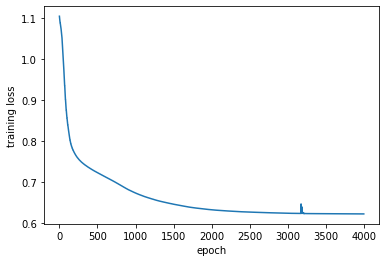

In [502]:
import matplotlib.pyplot as plt

# Plot training loss.
plt.plot(epoch_list, training_loss_list)
plt.xlabel('epoch')
plt.ylabel('training loss')
plt.show()

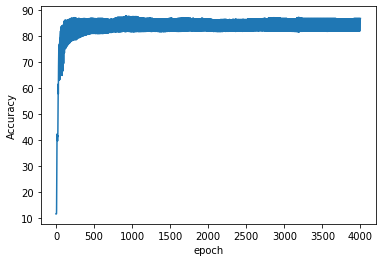

In [503]:
# Plot accuracy.
plt.plot(epoch_list, accuracy_list)
plt.xlabel('epoch')
plt.ylabel('Accuracy')
plt.show()

### Compute Accuracy

In [504]:
# Load the model with the maximum validation accuracy.
my_model = MLP2(input_layer_size, first_hidden_layer_size, second_hidden_layer_size)
my_model.load_state_dict(torch.load(PATH))
my_model.eval()
test_accuracy, predicted_test_labels = test_model(my_model, test_data, actual_test_labels)
print("Test accuracy: ", test_accuracy)

Test accuracy:  86.68555240793201


### Compute Confusion Matrix

In [505]:
from sklearn.metrics import confusion_matrix

actual_test_labels_np = actual_test_labels.numpy()

_, final_predicted_test_labels = torch.max(predicted_test_labels.data, 1)
final_predicted_test_labels_np = final_predicted_test_labels.numpy()

# Rows: true label  
# Columns: predicted label
confusion_matrix = confusion_matrix(actual_test_labels_np, final_predicted_test_labels_np)

dermatological_categories = ["AK", "NORM", "SBL"]
confusion_matrix_dataframe = pd.DataFrame(data = confusion_matrix, index = dermatological_categories, columns = dermatological_categories)

confusion_matrix_dataframe

,AK,NORM,SBL
AK,273,15,10
NORM,15,311,0
SBL,50,4,28


In [506]:
# Save confusion matrix in a csv file.
confusion_matrix_np = np.array(confusion_matrix)

np.savetxt(current_case_best_model_directory + "\\confusion_matrix.csv", confusion_matrix_np, delimiter = ',')

### Compute F1-Score

In [507]:
from sklearn.metrics import f1_score

test_f1_score = f1_score(actual_test_labels_np, final_predicted_test_labels_np, average = 'macro')
print("Test F1-Score: ", test_f1_score)

Test F1-Score:  0.7577759881372398


In [508]:
# Save test accuracy and F1-score to a csv file.
test_results_np = np.array( [test_accuracy, test_f1_score] )
np.savetxt(current_case_best_model_directory + "\\accuracy_f1_score.csv", test_results_np, delimiter = ',')